# Probability

This IPy notebook acts as supporting material for topics covered in **Chapter 13 Quantifying Uncertainty**, **Chapter 14 Probabilistic Reasoning**, **Chapter 15 Probabilistic Reasoning over Time**, **Chapter 16 Making Simple Decisions** and parts of **Chapter 25 Robotics** of the book* Artificial Intelligence: A Modern Approach*. This notebook makes use of the implementations in probability.py module. Let us import everything from the probability module. It might be helpful to view the source of some of our implementations. Please refer to the Introductory IPy file for more details on how to do so.

In [1]:
from collections import defaultdict
import numpy as np

## CONTENTS
- Probability Distribution
    - Joint probability distribution
    - Inference using full joint distributions
<br>
- Bayesian Networks
    - BayesNode
    - BayesNet
    - Exact Inference in Bayesian Networks
        - Enumeration
        - Variable elimination
    - Approximate Inference in Bayesian Networks
        - Prior sample
        - Rejection sampling
        - Likelihood weighting
        - Gibbs sampling

## PROBABILITY DISTRIBUTION

Let us begin by specifying discrete probability distributions. The class **ProbDist** defines a discrete probability distribution. We name our random variable and then assign probabilities to the different values of the random variable. Assigning probabilities to the values works similar to that of using a dictionary with keys being the Value and we assign to it the probability. This is possible because of the magic methods **_ _getitem_ _**  and **_ _setitem_ _** which store the probabilities in the prob dict of the object. You can keep the source window open alongside while playing with the rest of the code to get a better understanding.

In [3]:
class ProbDist:
    """A discrete probability distribution. You name the random variable
    in the constructor, then assign and query probability of values.
    >>> P = ProbDist('Flip'); P['H'], P['T'] = 0.25, 0.75; P['H']
    0.25
    >>> P = ProbDist('X', {'lo': 125, 'med': 375, 'hi': 500})
    >>> P['lo'], P['med'], P['hi']
    (0.125, 0.375, 0.5)
    """

    def __init__(self, varname='?', freqs=None):
        """If freqs is given, it is a dictionary of values - frequency pairs,
        then ProbDist is normalized."""
        self.prob = {}
        self.varname = varname
        self.values = []
        if freqs:
            for (v, p) in freqs.items():
                self[v] = p
            self.normalize()

    def __getitem__(self, val):
        """Given a value, return P(value)."""
        try:
            return self.prob[val]
        except KeyError:
            return 0

    def __setitem__(self, val, p):
        """Set P(val) = p."""
        if val not in self.values:
            self.values.append(val)
        self.prob[val] = p

    def normalize(self):
        """Make sure the probabilities of all values sum to 1.
        Returns the normalized distribution.
        Raises a ZeroDivisionError if the sum of the values is 0."""
        total = sum(self.prob.values())
        if not np.isclose(total, 1.0):
            for val in self.prob:
                self.prob[val] /= total
        return self

    def show_approx(self, numfmt='{:.3g}'):
        """Show the probabilities rounded and sorted by key, for the
        sake of portable doctests."""
        return ', '.join([('{}: ' + numfmt).format(v, p)
                          for (v, p) in sorted(self.prob.items())])

    def __repr__(self):
        return "P({})".format(self.varname)

In [4]:
p = ProbDist('Flip')
p['H'], p['T'] = 0.25, 0.75
p['T']

0.75

The first parameter of the constructor **varname** has a default value of '?'. So if the name is not passed it defaults to ?. The keyword argument **freqs** can be a dictionary of values of random variable: probability. These are then normalized such that the probability values sum upto 1 using the **normalize** method.

In [5]:
p = ProbDist(freqs={'low': 125, 'medium': 375, 'high': 500})
p.varname

'?'

In [6]:
(p['low'], p['medium'], p['high'])

(0.125, 0.375, 0.5)

Besides the **prob** and **varname** the object also separately keeps track of all the values of the distribution in a list called **values**. Every time a new value is assigned a probability it is appended to this list, This is done inside the **_ _setitem_ _** method.

In [7]:
p.values

['low', 'medium', 'high']

The distribution by default is not normalized if values are added incrementally. We can still force normalization by invoking the **normalize** method.

In [11]:
p = ProbDist('Y')
p['Cat'] = 50
p['Dog'] = 114
p['Mice'] = 64
p['Bunny'] = 5
(p['Cat'], p['Dog'], p['Mice'], p['Bunny'])

(50, 114, 64, 5)

In [12]:
p.normalize()
(p['Cat'], p['Dog'], p['Mice'], p['Bunny'])

(0.2145922746781116,
 0.4892703862660944,
 0.27467811158798283,
 0.02145922746781116)

It is also possible to display the approximate values upto decimals using the **show_approx** method.

In [13]:
p.show_approx()

'Bunny: 0.0215, Cat: 0.215, Dog: 0.489, Mice: 0.275'

## Joint Probability Distribution

The helper function **event_values** returns a tuple of the values of variables in event. An event is specified by a dict where the keys are the names of variables and the corresponding values are the value of the variable. Variables are specified with a list. The ordering of the returned tuple is same as those of the variables.


Alternatively if the event is specified by a list or tuple of equal length of the variables. Then the events tuple is returned as it is.

In [14]:
def event_values(event, variables):
    """Return a tuple of the values of variables in event.
    >>> event_values ({'A': 10, 'B': 9, 'C': 8}, ['C', 'A'])
    (8, 10)
    >>> event_values ((1, 2), ['C', 'A'])
    (1, 2)
    """
    if isinstance(event, tuple) and len(event) == len(variables):
        return event
    else:
        return tuple([event[var] for var in variables])

In [15]:
event = {'A': 10, 'B': 9, 'C': 8}
variables = ['C', 'A']
event_values(event, variables)

(8, 10)

In [16]:
event_values((1, 2), ['C', 'A'])

(1, 2)

_A probability model is completely determined by the joint distribution for all of the random variables._ (**Section 13.3**) The probability module implements these as the class **JointProbDist** which inherits from the **ProbDist** class. This class specifies a discrete probability distribute over a set of variables.

In [17]:
class JointProbDist(ProbDist):
    """A discrete probability distribute over a set of variables.
    >>> P = JointProbDist(['X', 'Y']); P[1, 1] = 0.25
    >>> P[1, 1]
    0.25
    >>> P[dict(X=0, Y=1)] = 0.5
    >>> P[dict(X=0, Y=1)]
    0.5"""

    def __init__(self, variables):
        self.prob = {}
        self.variables = variables
        self.vals = defaultdict(list)

    def __getitem__(self, values):
        """Given a tuple or dict of values, return P(values)."""
        values = event_values(values, self.variables)
        return ProbDist.__getitem__(self, values)

    def __setitem__(self, values, p):
        """Set P(values) = p.  Values can be a tuple or a dict; it must
        have a value for each of the variables in the joint. Also keep track
        of the values we have seen so far for each variable."""
        values = event_values(values, self.variables)
        self.prob[values] = p
        for var, val in zip(self.variables, values):
            if val not in self.vals[var]:
                self.vals[var].append(val)

    def values(self, var):
        """Return the set of possible values for a variable."""
        return self.vals[var]

    def __repr__(self):
        return "P({})".format(self.variables)


Values for a Joint Distribution is a an ordered tuple in which each item corresponds to the value associate with a particular variable. For Joint Distribution of X, Y where X, Y take integer values this can be something like (18, 19).

To specify a Joint distribution we first need an ordered list of variables.

In [18]:
variables = ['X', 'Y']
j = JointProbDist(variables)
j

P(['X', 'Y'])

Like the **ProbDist** class **JointProbDist** also employes magic methods to assign probability to different values.
The probability can be assigned in either of the two formats for all possible values of the distribution. The **event_values** call inside  **_ _getitem_ _**  and **_ _setitem_ _** does the required processing to make this work.

In [19]:
j[1,1] = 0.2
j[dict(X=0, Y=1)] = 0.5

(j[1,1], j[0,1])

(0.2, 0.5)

What about other probabilities?

In [20]:
j[0,0]

0

In [21]:
j[1,0]

0

It is also possible to list all the values for a particular variable using the **values** method.

In [22]:
j.values('X')

[1, 0]

## Inference Using Full Joint Distributions

In this section we use Full Joint Distributions to calculate the posterior distribution given some evidence. We represent evidence by using a python dictionary with variables as dict keys and dict values representing the values.

This is illustrated in **Section 13.3** of the book. The functions **enumerate_joint** and **enumerate_joint_ask** implement this functionality. Under the hood they implement **Equation 13.9** from the book.

$$\textbf{P}(X | \textbf{e}) = \alpha \textbf{P}(X, \textbf{e}) = \alpha \sum_{y} \textbf{P}(X, \textbf{e}, \textbf{y})$$

Here **α** is the normalizing factor. **X** is our query variable and **e** is the evidence. According to the equation we enumerate on the remaining variables **y** (not in evidence or query variable) i.e. all possible combinations of **y**

We will be using the same example as the book. Let us create the full joint distribution from **Figure 13.3**.  

In [23]:
full_joint = JointProbDist(['Cavity', 'Toothache', 'Catch'])
full_joint[dict(Cavity=True, Toothache=True, Catch=True)] = 0.108
full_joint[dict(Cavity=True, Toothache=True, Catch=False)] = 0.012
full_joint[dict(Cavity=True, Toothache=False, Catch=True)] = 0.016
full_joint[dict(Cavity=True, Toothache=False, Catch=False)] = 0.064
full_joint[dict(Cavity=False, Toothache=True, Catch=True)] = 0.072
full_joint[dict(Cavity=False, Toothache=False, Catch=True)] = 0.144
full_joint[dict(Cavity=False, Toothache=True, Catch=False)] = 0.008
full_joint[dict(Cavity=False, Toothache=False, Catch=False)] = 0.576

Let us now look at the **enumerate_joint** function returns the sum of those entries in P consistent with e,provided variables is P's remaining variables (the ones not in e). Here, P refers to the full joint distribution. The function uses a recursive call in its implementation. The first parameter **variables** refers to remaining variables. The function in each recursive call keeps on variable constant while varying others.

In [24]:
def extend(s, var, val):
    """Copy dict s and extend it by setting var to val; return copy."""
    return {**s, var: val}

def enumerate_joint(variables, e, P):
    """Return the sum of those entries in P consistent with e,
    provided variables is P's remaining variables (the ones not in e)."""
    if not variables:
        return P[e]
    Y, rest = variables[0], variables[1:]
    return sum([enumerate_joint(rest, extend(e, Y, y), P)
                for y in P.values(Y)])

Let us assume we want to find **P(Toothache=True)**. This can be obtained by marginalization (**Equation 13.6**). We can use **enumerate_joint** to solve for this by taking Toothache=True as our evidence. **enumerate_joint** will return the sum of probabilities consistent with evidence i.e. Marginal Probability.

In [25]:
evidence = dict(Toothache=True)
variables = ['Cavity', 'Catch'] # variables not part of evidence
ans1 = enumerate_joint(variables, evidence, full_joint)
ans1

0.19999999999999998

You can verify the result from our definition of the full joint distribution. We can use the same function to find more complex probabilities like **P(Cavity=True and Toothache=True)**

In [26]:
evidence = dict(Cavity=True, Toothache=True)
variables = ['Catch'] # variables not part of evidence
ans2 = enumerate_joint(variables, evidence, full_joint)
ans2

0.12

In [27]:
full_joint

P(['Cavity', 'Toothache', 'Catch'])

In [28]:
full_joint.values('Cavity')

[True, False]

In [29]:
full_joint[dict(Toothache=True, Cavity=True, Catch=True)]

0.108

In [32]:
full_joint[dict(Toothache=False, Cavity=True, Catch=False)]

0.064

Being able to find sum of probabilities satisfying given evidence allows us to compute conditional probabilities like **P(Cavity=True | Toothache=True)** as we can rewrite this as $$P(Cavity=True | Toothache = True) = \frac{P(Cavity=True \ and \ Toothache=True)}{P(Toothache=True)}$$

We have already calculated both the numerator and denominator.

In [33]:
ans2/ans1

0.6

In [34]:
enumerate_joint(['Catch'], dict(Cavity=True, Toothache=True), full_joint)/enumerate_joint(['Cavity', 'Catch'], dict(Toothache=True), full_joint)

0.6

We might be interested in the probability distribution of a particular variable conditioned on some evidence. This can involve doing calculations like above for each possible value of the variable. This has been implemented slightly differently  using normalization in the function **enumerate_joint_ask** which returns a probability distribution over the values of the variable **X**, given the {var:val} observations **e**, in the **JointProbDist P**. The implementation of this function calls **enumerate_joint** for each value of the query variable and passes **extended evidence** with the new evidence having **X = x<sub>i</sub>**. This is followed by normalization of the obtained distribution.

In [35]:
def enumerate_joint_ask(X, e, P):
    """Return a probability distribution over the values of the variable X,
    given the {var:val} observations e, in the JointProbDist P. [Section 13.3]
    >>> P = JointProbDist(['X', 'Y'])
    >>> P[0,0] = 0.25; P[0,1] = 0.5; P[1,1] = P[2,1] = 0.125
    >>> enumerate_joint_ask('X', dict(Y=1), P).show_approx()
    '0: 0.667, 1: 0.167, 2: 0.167'
    """
    assert X not in e, "Query variable must be distinct from evidence"
    Q = ProbDist(X)  # probability distribution for X, initially empty
    Y = [v for v in P.variables if v != X and v not in e]  # hidden variables.
    for xi in P.values(X):
        Q[xi] = enumerate_joint(Y, extend(e, X, xi), P)
    return Q.normalize()

Let us find **P(Cavity | Toothache=True)** using **enumerate_joint_ask**.

In [36]:
query_variable = 'Cavity'
evidence = dict(Toothache=True)
ans = enumerate_joint_ask(query_variable, evidence, full_joint)
(ans[True], ans[False])

(0.6, 0.39999999999999997)

You can verify that the first value is the same as we obtained earlier by manual calculation.

## BAYESIAN NETWORKS

A Bayesian network is a representation of the joint probability distribution encoding a collection of conditional independence statements.

A Bayes Network is implemented as the class **BayesNet**. It consisits of a collection of nodes implemented by the class **BayesNode**. The implementation in the above mentioned classes focuses only on boolean variables. Each node is associated with a variable and it contains a **conditional probabilty table (cpt)**. The **cpt** represents the probability distribution of the variable conditioned on its parents **P(X | parents)**.

Let us dive into the **BayesNode** implementation.

In [37]:
class BayesNode:
    """A conditional probability distribution for a boolean variable,
    P(X | parents). Part of a BayesNet."""

    def __init__(self, X, parents, cpt):
        """X is a variable name, and parents a sequence of variable
        names or a space-separated string.  cpt, the conditional
        probability table, takes one of these forms:

        * A number, the unconditional probability P(X=true). You can
          use this form when there are no parents.

        * A dict {v: p, ...}, the conditional probability distribution
          P(X=true | parent=v) = p. When there's just one parent.

        * A dict {(v1, v2, ...): p, ...}, the distribution P(X=true |
          parent1=v1, parent2=v2, ...) = p. Each key must have as many
          values as there are parents. You can use this form always;
          the first two are just conveniences.

        In all cases the probability of X being false is left implicit,
        since it follows from P(X=true).

        >>> X = BayesNode('X', '', 0.2)
        >>> Y = BayesNode('Y', 'P', {T: 0.2, F: 0.7})
        >>> Z = BayesNode('Z', 'P Q',
        ...    {(T, T): 0.2, (T, F): 0.3, (F, T): 0.5, (F, F): 0.7})
        """
        if isinstance(parents, str):
            parents = parents.split()

        # We store the table always in the third form above.
        if isinstance(cpt, (float, int)):  # no parents, 0-tuple
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # one parent, 1-tuple
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v,): p for v, p in cpt.items()}

        assert isinstance(cpt, dict)
        for vs, p in cpt.items():
            assert isinstance(vs, tuple) and len(vs) == len(parents)
            assert all(isinstance(v, bool) for v in vs)
            assert 0 <= p <= 1

        self.variable = X
        self.parents = parents
        self.cpt = cpt
        self.children = []

    def p(self, value, event):
        """Return the conditional probability
        P(X=value | parents=parent_values), where parent_values
        are the values of parents in event. (event must assign each
        parent a value.)
        >>> bn = BayesNode('X', 'Burglary', {T: 0.2, F: 0.625})
        >>> bn.p(False, {'Burglary': False, 'Earthquake': True})
        0.375"""
        assert isinstance(value, bool)
        ptrue = self.cpt[event_values(event, self.parents)]
        return ptrue if value else 1 - ptrue

    def sample(self, event):
        """Sample from the distribution for this variable conditioned
        on event's values for parent_variables. That is, return True/False
        at random according with the conditional probability given the
        parents."""
        return probability(self.p(True, event))

    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))

The constructor takes in the name of **variable**, **parents** and **cpt**. Here **variable** is a the name of the variable like 'Earthquake'. **parents** should a list or space separate string with variable names of parents. The conditional probability table is a dict {(v1, v2, ...): p, ...}, the distribution P(X=true | parent1=v1, parent2=v2, ...) = p. Here the keys are combination of boolean values that the parents take. The length and order of the values in keys should be same as the supplied **parent** list/string. In all cases the probability of X being false is left implicit, since it follows from P(X=true).

The example below where we implement the network shown in **Figure 14.3** of the book will make this more clear.

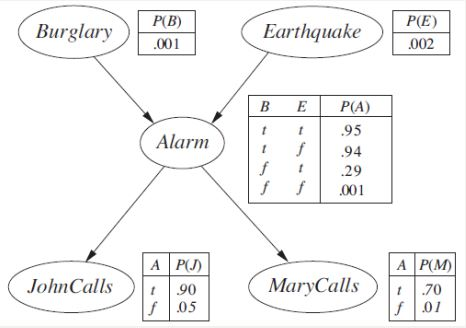

The alarm node can be made as follows:

In [38]:
alarm_node = BayesNode('Alarm', ['Burglary', 'Earthquake'],
                       {(True, True): 0.95,(True, False): 0.94, (False, True): 0.29, (False, False): 0.001})

It is possible to avoid using a tuple when there is only a single parent. So an alternative format for the **cpt** is

In [39]:
john_node = BayesNode('JohnCalls', ['Alarm'], {True: 0.90, False: 0.05})
mary_node = BayesNode('MaryCalls', 'Alarm', {(True, ): 0.70, (False, ): 0.01}) # Using string for parents.
# Equivalant to john_node definition.

The general format used for the alarm node always holds. For nodes with no parents we can also use.

In [40]:
burglary_node = BayesNode('Burglary', '', 0.001)
earthquake_node = BayesNode('Earthquake', '', 0.002)

It is possible to use the node for lookup function using the **p** method. The method takes in two arguments **value** and **event**. Event must be a dict of the type {variable:values, ..} The value corresponds to the value of the variable we are interested in (False or True).The method returns the conditional probability **P(X=value | parents=parent_values)**, where parent_values are the values of parents in event. (event must assign each parent a value.)

In [41]:
john_node.p(False, {'Alarm': True, 'Burglary': True}) # P(JohnCalls=False | Alarm=True)

0.09999999999999998

With all the information about nodes present it is possible to construct a Bayes Network using **BayesNet**. The **BayesNet** class does not take in nodes as input but instead takes a list of **node_specs**. An entry in **node_specs** is a tuple of the parameters we use to construct a **BayesNode** namely **(X, parents, cpt)**. **node_specs** must be ordered with parents before children.

In [42]:
class BayesNet:
    """Bayesian network containing only boolean-variable nodes."""

    def __init__(self, node_specs=None):
        """Nodes must be ordered with parents before children."""
        self.nodes = []
        self.variables = []
        node_specs = node_specs or []
        for node_spec in node_specs:
            self.add(node_spec)

    def add(self, node_spec):
        """Add a node to the net. Its parents must already be in the
        net, and its variable must not."""
        node = BayesNode(*node_spec)
        assert node.variable not in self.variables
        assert all((parent in self.variables) for parent in node.parents)
        self.nodes.append(node)
        self.variables.append(node.variable)
        for parent in node.parents:
            self.variable_node(parent).children.append(node)

    def variable_node(self, var):
        """Return the node for the variable named var.
        >>> burglary.variable_node('Burglary').variable
        'Burglary'"""
        for n in self.nodes:
            if n.variable == var:
                return n
        raise Exception("No such variable: {}".format(var))

    def variable_values(self, var):
        """Return the domain of var."""
        return [True, False]

    def __repr__(self):
        return 'BayesNet({0!r})'.format(self.nodes)

The constructor of **BayesNet** takes each item in **node_specs** and adds a **BayesNode** to its **nodes** object variable by calling the **add** method. **add** in turn adds  node to the net. Its parents must already be in the net, and its variable must not. Thus add allows us to grow a **BayesNet** given its parents are already present.

**burglary** global is an instance of **BayesNet** corresponding to the above example.

    T, F = True, False

    burglary = BayesNet([
        ('Burglary', '', 0.001),
        ('Earthquake', '', 0.002),
        ('Alarm', 'Burglary Earthquake',
         {(T, T): 0.95, (T, F): 0.94, (F, T): 0.29, (F, F): 0.001}),
        ('JohnCalls', 'Alarm', {T: 0.90, F: 0.05}),
        ('MaryCalls', 'Alarm', {T: 0.70, F: 0.01})
    ])

In [43]:
T, F = True, False

burglary = BayesNet([
    ('Burglary', '', 0.001),
    ('Earthquake', '', 0.002),
    ('Alarm', 'Burglary Earthquake',
     {(T, T): 0.95, (T, F): 0.94, (F, T): 0.29, (F, F): 0.001}),
    ('JohnCalls', 'Alarm', {T: 0.90, F: 0.05}),
    ('MaryCalls', 'Alarm', {T: 0.70, F: 0.01})
])

In [44]:
burglary

BayesNet([('Burglary', ''), ('Earthquake', ''), ('Alarm', 'Burglary Earthquake'), ('JohnCalls', 'Alarm'), ('MaryCalls', 'Alarm')])

**BayesNet** method **variable_node** allows to reach **BayesNode** instances inside a Bayes Net. It is possible to modify the **cpt** of the nodes directly using this method.

In [45]:
type(burglary.variable_node('Alarm'))

__main__.BayesNode

In [46]:
burglary.variable_node('Alarm').cpt

{(True, True): 0.95,
 (True, False): 0.94,
 (False, True): 0.29,
 (False, False): 0.001}

In [47]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-fre

In [48]:
!jupyter nbconvert --to pdf bayesnets.ipynb
from google.colab import files
files.download('bayesnets.pdf')

[NbConvertApp] Converting notebook bayesnets.ipynb to pdf
[NbConvertApp] Writing 144104 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 151220 bytes to bayesnets.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Likelihood Weighting

Rejection sampling takes a long time to run when the probability of finding consistent evidence is low. It is also slow for larger networks and more evidence variables.
Rejection sampling tends to reject a lot of samples if our evidence consists of a large number of variables. Likelihood Weighting solves this by fixing the evidence (i.e. not sampling it) and then using weights to make sure that our overall sampling is still consistent.

The pseudocode in **Figure 14.15** is implemented as **likelihood_weighting** and **weighted_sample**.

In [ ]:
import random

def probability(p):
    """Return true with probability p."""
    return p > random.uniform(0.0, 1.0)

def weighted_sample(bn, e):
    """Sample an event from bn that's consistent with the evidence e;
    return the event and its weight, the likelihood that the event
    accords to the evidence."""
    w = 1
    event = dict(e)  # boldface x in [Figure 14.15]
    for node in bn.nodes:
        Xi = node.variable
        if Xi in e:
            w *= node.p(e[Xi], event)
        else:
            event[Xi] = node.sample(event)
    return event, w


**weighted_sample** samples an event from Bayesian Network that's consistent with the evidence **e** and returns the event and its weight, the likelihood that the event accords to the evidence. It takes in two parameters **bn** the Bayesian Network and **e** the evidence.

The weight is obtained by multiplying **P(x<sub>i</sub> | parents(x<sub>i</sub>))** for each node in evidence. We set the values of **event = evidence** at the start of the function.

In [ ]:
weighted_sample(burglary, dict(Alarm=True))

In [ ]:
def likelihood_weighting(X, e, bn, N=10000):
    """Estimate the probability distribution of variable X given
    evidence e in BayesNet bn.  [Figure 14.15]
    >>> random.seed(1017)
    >>> likelihood_weighting('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.702, True: 0.298'
    """
    W = {x: 0 for x in bn.variable_values(X)}
    for j in range(N):
        sample, weight = weighted_sample(bn, e)  # boldface x, w in [Figure 14.15]
        W[sample[X]] += weight
    return ProbDist(X, W)

**likelihood_weighting** implements the algorithm to solve our inference problem. The code is similar to **rejection_sampling** but instead of adding one for each sample we add the weight obtained from **weighted_sampling**.

In [ ]:
likelihood_weighting('JohnCalls', dict(Alarm=True), burglary, 200).show_approx()

What other scenarios can we think of?

In [ ]:
# Fill in the other situation here:


Let's redefine our function to see what happens at each iterative step

In [ ]:
def likelihood_weighting(X, e, bn, N=10000, max_print=10):
    """Estimate the probability distribution of variable X given
    evidence e in BayesNet bn.  [Figure 14.15]
    >>> random.seed(1017)
    >>> likelihood_weighting('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.702, True: 0.298'
    """
    W = {x: 0 for x in bn.variable_values(X)}
    print(W)
    for j in range(N):
        sample, weight = weighted_sample(bn, e)  # boldface x, w in [Figure 14.15]
        if j < max_print:
            print(f'Our sample and weight @ {j} is {sample}, {weight}')
        W[sample[X]] += weight
        if j < max_print:
            print(f'Our W[sample[X]] @ {j} is {W[sample[X]]}')
    print(f'Our final sample and weight @ {j} is {sample}, {weight}')
    print(f'Our final W[sample[X]] @ {j} is {W[sample[X]]}')
    return ProbDist(X, W)

In [ ]:
likelihood_weighting('JohnCalls', dict(Alarm=True), burglary, 200).show_approx()

What about our other situation?

In [ ]:
# Fill in the other situation from above here:


# Lecture Ends Here. I will update the code blocks below later and update this notebook

## Exact Inference in Bayesian Networks

A Bayes Network is a more compact representation of the full joint distribution and like full joint distributions allows us to do inference i.e. answer questions about probability distributions of random variables given some evidence.

Exact algorithms don't scale well for larger networks. Approximate algorithms are explained in the next section.

### Inference by Enumeration

We apply techniques similar to those used for **enumerate_joint_ask** and **enumerate_joint** to draw inference from Bayesian Networks. **enumeration_ask** and **enumerate_all** implement the algorithm described in **Figure 14.9** of the book.

In [ ]:
def enumerate_all(variables, e, bn):
    """Return the sum of those entries in P(variables | e{others})
    consistent with e, where P is the joint distribution represented
    by bn, and e{others} means e restricted to bn's other variables
    (the ones other than variables). Parents must precede children in variables."""
    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    Ynode = bn.variable_node(Y)
    if Y in e:
        return Ynode.p(e[Y], e) * enumerate_all(rest, e, bn)
    else:
        return sum(Ynode.p(y, e) * enumerate_all(rest, extend(e, Y, y), bn)
                   for y in bn.variable_values(Y))

**enumerate_all** recursively evaluates a general form of the **Equation 14.4** in the book.

$$\textbf{P}(X | \textbf{e}) = α \textbf{P}(X, \textbf{e}) = α \sum_{y} \textbf{P}(X, \textbf{e}, \textbf{y})$$

such that **P(X, e, y)** is written in the form of product of conditional probabilities **P(variable | parents(variable))** from the Bayesian Network.

**enumeration_ask** calls **enumerate_all** on each value of query variable **X** and finally normalizes them.


In [ ]:
def enumeration_ask(X, e, bn):
    """Return the conditional probability distribution of variable X
    given evidence e, from BayesNet bn. [Figure 14.9]
    >>> enumeration_ask('Burglary', dict(JohnCalls=T, MaryCalls=T), burglary
    ...  ).show_approx()
    'False: 0.716, True: 0.284'"""
    assert X not in e, "Query variable must be distinct from evidence"
    Q = ProbDist(X)
    for xi in bn.variable_values(X):
        Q[xi] = enumerate_all(bn.variables, extend(e, X, xi), bn)
    return Q.normalize()

Let us solve the problem of finding out **P(Burglary=True | JohnCalls=True, MaryCalls=True)** using the **burglary** network. **enumeration_ask** takes three arguments **X** = variable name, **e** = Evidence (in form a dict like previously explained), **bn** = The Bayes Net to do inference on.

In [ ]:
ans_dist = enumeration_ask('Burglary', {'JohnCalls': True, 'MaryCalls': True}, burglary)
ans_dist[True]

### Variable Elimination

The enumeration algorithm can be improved substantially by eliminating repeated calculations. In enumeration we join the joint of all hidden variables. This is of exponential size for the number of hidden variables. Variable elimination employes interleaving join and marginalization.

Before we look into the implementation of Variable Elimination we must first familiarize ourselves with Factors.

In general we call a multidimensional array of type P(Y1 ... Yn | X1 ... Xm) a factor where some of Xs and Ys maybe assigned values. Factors are implemented in the probability module as the class **Factor**. They take as input **variables** and **cpt**.


#### Helper Functions

There are certain helper functions that help creating the **cpt** for the Factor given the evidence. Let us explore them one by one.

In [ ]:
class Factor:
    """A factor in a joint distribution."""

    def __init__(self, variables, cpt):
        self.variables = variables
        self.cpt = cpt

    def pointwise_product(self, other, bn):
        """Multiply two factors, combining their variables."""
        variables = list(set(self.variables) | set(other.variables))
        cpt = {event_values(e, variables): self.p(e) * other.p(e) for e in all_events(variables, bn, {})}
        return Factor(variables, cpt)

    def sum_out(self, var, bn):
        """Make a factor eliminating var by summing over its values."""
        variables = [X for X in self.variables if X != var]
        cpt = {event_values(e, variables): sum(self.p(extend(e, var, val)) for val in bn.variable_values(var))
               for e in all_events(variables, bn, {})}
        return Factor(variables, cpt)

    def normalize(self):
        """Return my probabilities; must be down to one variable."""
        assert len(self.variables) == 1
        return ProbDist(self.variables[0], {k: v for ((k,), v) in self.cpt.items()})

    def p(self, e):
        """Look up my value tabulated for e."""
        return self.cpt[event_values(e, self.variables)]

def make_factor(var, e, bn):
    """Return the factor for var in bn's joint distribution given e.
    That is, bn's full joint distribution, projected to accord with e,
    is the pointwise product of these factors for bn's variables."""
    node = bn.variable_node(var)
    variables = [X for X in [var] + node.parents if X not in e]
    cpt = {event_values(e1, variables): node.p(e1[var], e1)
           for e1 in all_events(variables, bn, e)}
    return Factor(variables, cpt)

**make_factor** is used to create the **cpt** and **variables** that will be passed to the constructor of **Factor**. We use **make_factor** for each variable. It takes in the arguments **var** the particular variable, **e** the evidence we want to do inference on, **bn** the bayes network.

Here **variables** for each node refers to a list consisting of the variable itself and the parents minus any variables that are part of the evidence. This is created by finding the **node.parents** and filtering out those that are not part of the evidence.

The **cpt** created is the one similar to the original **cpt** of the node with only rows that agree with the evidence.

In [ ]:
def all_events(variables, bn, e):
    """Yield every way of extending e with values for all variables."""
    if not variables:
        yield e
    else:
        X, rest = variables[0], variables[1:]
        for e1 in all_events(rest, bn, e):
            for x in bn.variable_values(X):
                yield extend(e1, X, x)

The **all_events** function is a recursive generator function which yields a key for the orignal **cpt** which is part of the node. This works by extending evidence related to the node, thus all the output from **all_events** only includes events that support the evidence. Given **all_events** is a generator function one such event is returned on every call.

We can try this out using the example on **Page 524** of the book. We will make **f**<sub>5</sub>(A) = P(m | A)

In [ ]:
f5 = make_factor('MaryCalls', {'JohnCalls': True, 'MaryCalls': True}, burglary)

In [ ]:
f5

In [ ]:
f5.cpt

In [ ]:
f5.variables

Here **f5.cpt** False key gives probability for **P(MaryCalls=True | Alarm = False)**. Due to our representation where we only store probabilities for only in cases where the node variable is True this is the same as the **cpt** of the BayesNode. Let us try a somewhat different example from the book where evidence is that the Alarm = True

In [ ]:
new_factor = make_factor('MaryCalls', {'Alarm': True}, burglary)

In [ ]:
new_factor.cpt

Here the **cpt** is for **P(MaryCalls | Alarm = True)**. Therefore the probabilities for True and False sum up to one. Note the difference between both the cases. Again the only rows included are those consistent with the evidence.

#### Operations on Factors

We are interested in two kinds of operations on factors. **Pointwise Product** which is used to created joint distributions and **Summing Out** which is used for marginalization.

**Factor.pointwise_product** implements a method of creating a joint via combining two factors. We take the union of **variables** of both the factors and then generate the **cpt** for the new factor using **all_events** function. Note that the given we have eliminated rows that are not consistent with the evidence. Pointwise product assigns new probabilities by multiplying rows similar to that in a database join.

In [ ]:
def pointwise_product(factors, bn):
    return reduce(lambda f, g: f.pointwise_product(g, bn), factors)

**pointwise_product** extends this operation to more than two operands where it is done sequentially in pairs of two.

**Factor.sum_out** makes a factor eliminating a variable by summing over its values. Again **events_all** is used to generate combinations for the rest of the variables.

In [ ]:
def sum_out(var, factors, bn):
    """Eliminate var from all factors by summing over its values."""
    result, var_factors = [], []
    for f in factors:
        (var_factors if var in f.variables else result).append(f)
    result.append(pointwise_product(var_factors, bn).sum_out(var, bn))
    return result

**sum_out** uses both **Factor.sum_out** and **pointwise_product** to finally eliminate a particular variable from all factors by summing over its values.

#### Elimination Ask

The algorithm described in **Figure 14.11** of the book is implemented by the function **elimination_ask**. We use this for inference. The key idea is that we eliminate the hidden variables by interleaving joining and marginalization. It takes in 3 arguments **X** the query variable, **e** the evidence variable and **bn** the Bayes network.

The algorithm creates factors out of Bayes Nodes in reverse order and eliminates hidden variables using **sum_out**. Finally it takes a point wise product of all factors and normalizes. Let us finally solve the problem of inferring

**P(Burglary=True | JohnCalls=True, MaryCalls=True)** using variable elimination.

In [ ]:
from functools import reduce
def is_hidden(var, X, e):
    """Is var a hidden variable when querying P(X|e)?"""
    return var != X and var not in e

def elimination_ask(X, e, bn):
    """Compute bn's P(X|e) by variable elimination. [Figure 14.11]
    >>> elimination_ask('Burglary', dict(JohnCalls=T, MaryCalls=T), burglary
    ...  ).show_approx()
    'False: 0.716, True: 0.284'"""
    assert X not in e, "Query variable must be distinct from evidence"
    factors = []
    for var in reversed(bn.variables):
        factors.append(make_factor(var, e, bn))
        if is_hidden(var, X, e):
            factors = sum_out(var, factors, bn)
    return pointwise_product(factors, bn).normalize()

In [ ]:
elimination_ask('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary).show_approx()

#### Elimination Ask Optimizations

`elimination_ask` has some critical point to consider and some optimizations could be performed:

- **Operation on factors**:

  `sum_out` and `pointwise_product` function used in `elimination_ask` is where space and time complexity arise in the variable elimination algorithm (AIMA3e pg. 526).

>The only trick is to notice that any factor that does not depend on the variable to be summed out can be moved outside the summation.

- **Variable ordering**:

  Elimination ordering is important, every choice of ordering yields a valid algorithm, but different orderings cause different intermediate factors to be generated during the calculation (AIMA3e pg. 527). In this case the algorithm applies a reversed order.

> In general, the time and space requirements of variable elimination are dominated by the size of the largest factor constructed during the operation of the algorithm. This in turn is determined by the order of elimination of variables and by the structure of the network. It turns out to be intractable to determine the optimal ordering, but several good heuristics are available. One fairly effective method is a greedy one: eliminate whichever variable minimizes the size of the next factor to be constructed.  

- **Variable relevance**
  
  Some variables could be irrelevant to resolve a query  (i.e. sums to 1). A variable elimination algorithm can therefore remove all these variables before evaluating the query (AIMA3e pg. 528).

> An optimization is to remove 'every variable that is not an ancestor of a query variable or evidence variable is irrelevant to the query'.

#### Runtime comparison
Let's see how the runtimes of these two algorithms compare.
We expect variable elimination to outperform enumeration by a large margin as we reduce the number of repetitive calculations significantly.

In [ ]:
%%timeit
enumeration_ask('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary).show_approx()

In [ ]:
%%timeit
elimination_ask('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary).show_approx()

In this test case we observe that variable elimination is slower than what we expected. It has something to do with number of threads, how Python tries to optimize things and  this happens because the network is very small, with just 5 nodes. The `elimination_ask` has some critical point and some optimizations must be perfomed as seen above.
<br>
Of course, for more complicated networks, variable elimination will be significantly faster and runtime will drop not just by a constant factor, but by a polynomial factor proportional to the number of nodes, due to the reduction in repeated calculations.

## Approximate Inference in Bayesian Networks

Exact inference fails to scale for very large and complex Bayesian Networks. This section covers implementation of randomized sampling algorithms, also called Monte Carlo algorithms.

In [ ]:
psource(BayesNode.sample)

Before we consider the different algorithms in this section let us look at the **BayesNode.sample** method. It samples from the distribution for this variable conditioned on event's values for parent_variables. That is, return True/False at random according to with the conditional probability given the parents. The **probability** function is a simple helper from **utils** module which returns True with the probability passed to it.

### Prior Sampling

The idea of Prior Sampling is to sample from the Bayesian Network in a topological order. We start at the top of the network and sample as per **P(X<sub>i</sub> | parents(X<sub>i</sub>)** i.e. the probability distribution from which the value is sampled is conditioned on the values already assigned to the variable's parents. This can be thought of as a simulation.

In [ ]:
def prior_sample(bn):
    """Randomly sample from bn's full joint distribution. The result
    is a {variable: value} dict. [Figure 14.13]"""
    event = {}
    for node in bn.nodes:
        event[node.variable] = node.sample(event)
    return event

The function **prior_sample** implements the algorithm described in **Figure 14.13** of the book. Nodes are sampled in the topological order. The old value of the event is passed as evidence for parent values. We will use the Bayesian Network in **Figure 14.12** to try out the **prior_sample**

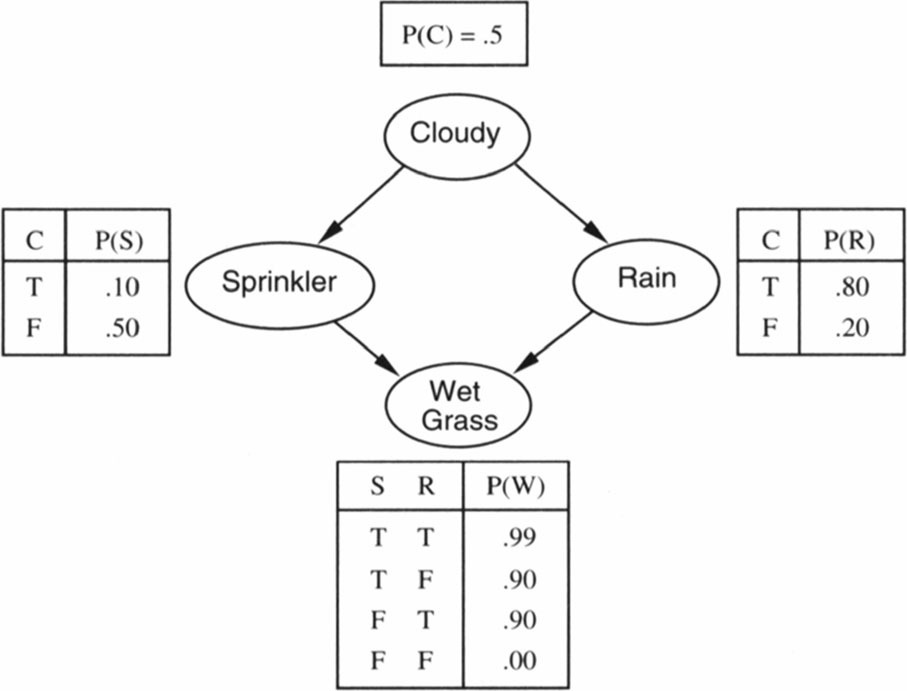

Traversing the graph in topological order is important.
There are two possible topological orderings for this particular directed acyclic graph.
<br>
1. `Cloudy -> Sprinkler -> Rain -> Wet Grass`
2. `Cloudy -> Rain -> Sprinkler -> Wet Grass`
<br>
<br>
We can follow any of the two orderings to sample from the network.
Any ordering other than these two, however, cannot be used.
<br>
One way to think about this is that `Cloudy` can be seen as a precondition of both `Rain` and `Sprinkler` and just like we have seen in planning, preconditions need to be satisfied before a certain action can be executed.
<br>
We store the samples on the observations. Let us find **P(Rain=True)** by taking 1000 random samples from the network.

In [ ]:
N = 1000
all_observations = [prior_sample(sprinkler) for x in range(N)]

Now we filter to get the observations where Rain = True

In [ ]:
rain_true = [observation for observation in all_observations if observation['Rain'] == True]

Finally, we can find **P(Rain=True)**

In [ ]:
answer = len(rain_true) / N
print(answer)

Sampling this another time might give different results as we have no control over the distribution of the random samples

In [ ]:
N = 1000
all_observations = [prior_sample(sprinkler) for x in range(N)]
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
answer = len(rain_true) / N
print(answer)

To evaluate a conditional distribution. We can use a two-step filtering process. We first separate out the variables that are consistent with the evidence. Then for each value of query variable, we can find probabilities. For example to find **P(Cloudy=True | Rain=True)**. We have already filtered out the values consistent with our evidence in **rain_true**. Now we apply a second filtering step on **rain_true** to find **P(Rain=True and Cloudy=True)**

In [ ]:
rain_and_cloudy = [observation for observation in rain_true if observation['Cloudy'] == True]
answer = len(rain_and_cloudy) / len(rain_true)
print(answer)

### Rejection Sampling

Rejection Sampling is based on an idea similar to what we did just now.
First, it generates samples from the prior distribution specified by the network.
Then, it rejects all those that do not match the evidence.
<br>
Rejection sampling is advantageous only when we know the query beforehand.
While prior sampling generally works for any query, it might fail in some scenarios.
<br>
Let's say we have a generic Bayesian network and we have evidence `e`, and we want to know how many times a state `A` is true, given evidence `e` is true.
Normally, prior sampling can answer this question, but let's assume that the probability of evidence `e` being true in our actual probability distribution is very small.
In this situation, it might be possible that sampling never encounters a data-point where `e` is true.
If our sampled data has no instance of `e` being true, `P(e) = 0`, and therefore `P(A | e) / P(e) = 0/0`, which is undefined.
We cannot find the required value using this sample.
<br>
We can definitely increase the number of sample points, but we can never guarantee that we will encounter the case where `e` is non-zero (assuming our actual probability distribution has atleast one case where `e` is true).
To guarantee this, we would have to consider every single data point, which means we lose the speed advantage that approximation provides us and we essentially have to calculate the exact inference model of the Bayesian network.
<br>
<br>
Rejection sampling will be useful in this situation, as we already know the query.
<br>
While sampling from the network, we will reject any sample which is inconsistent with the evidence variables of the given query (in this example, the only evidence variable is `e`).
We will only consider samples that do not violate **any** of the evidence variables.
In this way, we will have enough data with the required evidence to infer queries involving a subset of that evidence.
<br>
<br>
The function **rejection_sampling** implements the algorithm described by **Figure 14.14**

In [ ]:
psource(rejection_sampling)

The function keeps counts of each of the possible values of the Query variable and increases the count when we see an observation consistent with the evidence. It takes in input parameters **X** - The Query Variable, **e** - evidence, **bn** - Bayes net and **N** - number of prior samples to generate.

**consistent_with** is used to check consistency.

In [ ]:
psource(consistent_with)

To answer **P(Cloudy=True | Rain=True)**

In [ ]:
p = rejection_sampling('Cloudy', dict(Rain=True), sprinkler, 1000)
p[True]

### Likelihood Weighting

Rejection sampling takes a long time to run when the probability of finding consistent evidence is low. It is also slow for larger networks and more evidence variables.
Rejection sampling tends to reject a lot of samples if our evidence consists of a large number of variables. Likelihood Weighting solves this by fixing the evidence (i.e. not sampling it) and then using weights to make sure that our overall sampling is still consistent.

The pseudocode in **Figure 14.15** is implemented as **likelihood_weighting** and **weighted_sample**.

In [ ]:
import random

def probability(p):
    """Return true with probability p."""
    return p > random.uniform(0.0, 1.0)

def weighted_sample(bn, e):
    """Sample an event from bn that's consistent with the evidence e;
    return the event and its weight, the likelihood that the event
    accords to the evidence."""
    w = 1
    event = dict(e)  # boldface x in [Figure 14.15]
    for node in bn.nodes:
        Xi = node.variable
        if Xi in e:
            w *= node.p(e[Xi], event)
        else:
            event[Xi] = node.sample(event)
    return event, w


**weighted_sample** samples an event from Bayesian Network that's consistent with the evidence **e** and returns the event and its weight, the likelihood that the event accords to the evidence. It takes in two parameters **bn** the Bayesian Network and **e** the evidence.

The weight is obtained by multiplying **P(x<sub>i</sub> | parents(x<sub>i</sub>))** for each node in evidence. We set the values of **event = evidence** at the start of the function.

In [ ]:
weighted_sample(sprinkler, dict(Rain=True))

In [ ]:
def likelihood_weighting(X, e, bn, N=10000):
    """Estimate the probability distribution of variable X given
    evidence e in BayesNet bn.  [Figure 14.15]
    >>> random.seed(1017)
    >>> likelihood_weighting('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.702, True: 0.298'
    """
    W = {x: 0 for x in bn.variable_values(X)}
    for j in range(N):
        sample, weight = weighted_sample(bn, e)  # boldface x, w in [Figure 14.15]
        W[sample[X]] += weight
    return ProbDist(X, W)

**likelihood_weighting** implements the algorithm to solve our inference problem. The code is similar to **rejection_sampling** but instead of adding one for each sample we add the weight obtained from **weighted_sampling**.

In [ ]:
likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

### Gibbs Sampling

In likelihood sampling, it is possible to obtain low weights in cases where the evidence variables reside at the bottom of the Bayesian Network. This can happen because influence only propagates downwards in likelihood sampling.

Gibbs Sampling solves this. The implementation of **Figure 14.16** is provided in the function **gibbs_ask**

In [ ]:
psource(gibbs_ask)

In **gibbs_ask** we initialize the non-evidence variables to random values. And then select non-evidence variables and sample it from **P(Variable | value in the current state of all remaining vars) ** repeatedly sample. In practice, we speed this up by using **markov_blanket_sample** instead. This works because terms not involving the variable get canceled in the calculation. The arguments for **gibbs_ask** are similar to **likelihood_weighting**

In [ ]:
gibbs_ask('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

#### Runtime analysis
Let's take a look at how much time each algorithm takes.

In [ ]:
%%timeit
all_observations = [prior_sample(sprinkler) for x in range(1000)]
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
len([observation for observation in rain_true if observation['Cloudy'] == True]) / len(rain_true)

In [ ]:
%%timeit
rejection_sampling('Cloudy', dict(Rain=True), sprinkler, 1000)

In [ ]:
%%timeit
likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200)

In [ ]:
%%timeit
gibbs_ask('Cloudy', dict(Rain=True), sprinkler, 200)

As expected, all algorithms have a very similar runtime.
However, rejection sampling would be a lot faster and more accurate when the probabiliy of finding data-points consistent with the required evidence is small.
<br>
Likelihood weighting is the fastest out of all as it doesn't involve rejecting samples, but also has a quite high variance.